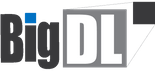

##### Copyright 2016 The BigDL Authors.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Tutorial of penalizing underestimation

In most scenarios, we want predicted value of forecast to be as close as possible to real value, so we use loss functions such as MSE or MAE to achieve this purpose. However, in some industrial scenarios, such as workload prediction, the adverse effect caused by predicted value being less than real value is far greater than that caused by predicted value being greater than real value. Therefore, in this case, we hope to **reduce underestimation as well as avoid too much prediction accuracy loss**.

Here, we use TCNForecaster and a common time series dataset [nyc taxi](https://raw.githubusercontent.com/numenta/NAB/v1.0/data/realKnownCause/nyc_taxi.csv) to illustrate how to penalize underestimation based on a built-in loss function **LinexLoss**.

## Helper Functions

This section defines some helper functions to be used in the following procedures. You can refer to it later when they're used.

In [6]:
import matplotlib.pyplot as plt
def plot_predict_actual_values(date, y_pred, y_test, ylabel):
    """
    plot the predicted values and actual values (for the test data)
    """
    fig, axs = plt.subplots(figsize=(16,6))

    axs.plot(date, y_pred, color='red', label='predicted values')
    axs.plot(date, y_test, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel('test datetime')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left')
    plt.show()

In [7]:
def calculate_underestimation_portion(y_pred, y_true):
    sample = y_pred.shape[0]
    underestimation = np.sum(y_pred < y_true)
    return underestimation / sample

## Step1 : Prepare Data

In [52]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from bigdl.chronos.data.repo_dataset import get_public_dataset


def get_tsdata():
    name = 'nyc_taxi'
    tsdata_train, _, tsdata_test = get_public_dataset(name)
    stand_scaler = StandardScaler()
    for tsdata in [tsdata_train, tsdata_test]:
        tsdata.impute(mode="linear")\
              .scale(stand_scaler, fit=(tsdata is tsdata_train))
    return tsdata_train, tsdata_test

tsdata_train, tsdata_test = get_tsdata()
horizon = 1
lookback = 48
x_train, y_train = tsdata_train.roll(horizon=horizon, lookback=lookback).to_numpy()
x_test, y_test = tsdata_test.roll(horizon=horizon, lookback=lookback).to_numpy()

## Step2 : Train TCNForecaster with MSE Loss

In [ ]:
from bigdl.chronos.forecaster import TCNForecaster
# build model
forecaster = TCNForecaster(past_seq_len=lookback,
                           future_seq_len=horizon,
                           input_feature_num=1,
                           output_feature_num=1,
                           num_channels=[16]*3,
                           loss="mse")

In [ ]:
forecaster.fit(data=(x_train, y_train), epochs=5)

In [82]:
y_pred = forecaster.predict(x_test)
y_pred_unscale = tsdata_test.unscale_numpy(y_pred).squeeze()
y_true_unscale = tsdata_test.unscale_numpy(y_test).squeeze()

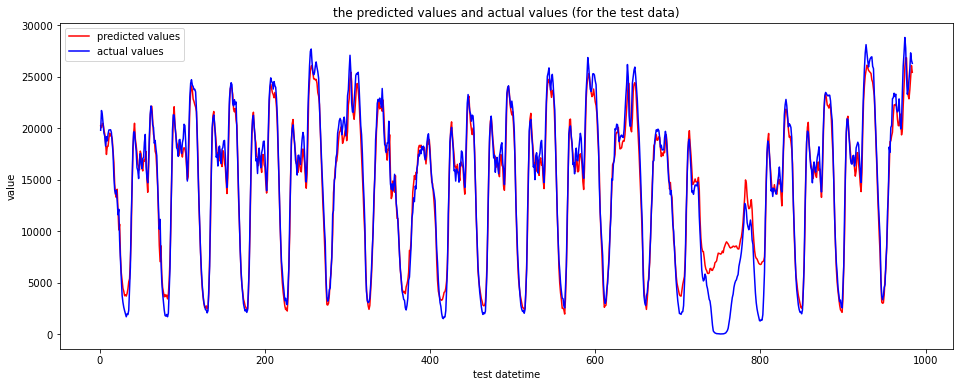

In [83]:
plot_predict_actual_values(range(1, y_pred_unscale.shape[0]+1), y_pred_unscale, y_true_unscale, "value")

It can be seen from above image that in most of the "peaks" of the curve, predicted value is lower than real value. Further, through `calculate_underestimation_portion`, we can quantitatively calculate the proportion of underestimated predictions in all test samples. It can be seen that after training with MSE loss, underestimated samples account for **57.7%** of all samples.

In [85]:
calculate_underestimation_portion(y_pred_unscale, y_true_unscale)

0.5772357723577236

## Step3 : Train TCNForecaster with Linex Loss

The parameter `a` in `LinexLoss` is important and need to set manually. When `a` is set to > 0, this loss panelize underestimate more.

In [ ]:
from bigdl.chronos.forecaster import TCNForecaster
from bigdl.chronos.pytorch.loss import LinexLoss
# build model
forecaster = TCNForecaster(past_seq_len=lookback,
                           future_seq_len=horizon,
                           input_feature_num=1,
                           output_feature_num=1,
                           num_channels=[16]*3,
                           loss=LinexLoss(a=1))

Linex loss converges relatively slowly, so may fit with more epochs.

In [ ]:
forecaster.fit(data=(x_train, y_train), epochs=10)

In [77]:
y_pred = forecaster.predict(x_test)
y_pred_unscale = tsdata_test.unscale_numpy(y_pred).squeeze()
y_true_unscale = tsdata_test.unscale_numpy(y_test).squeeze()

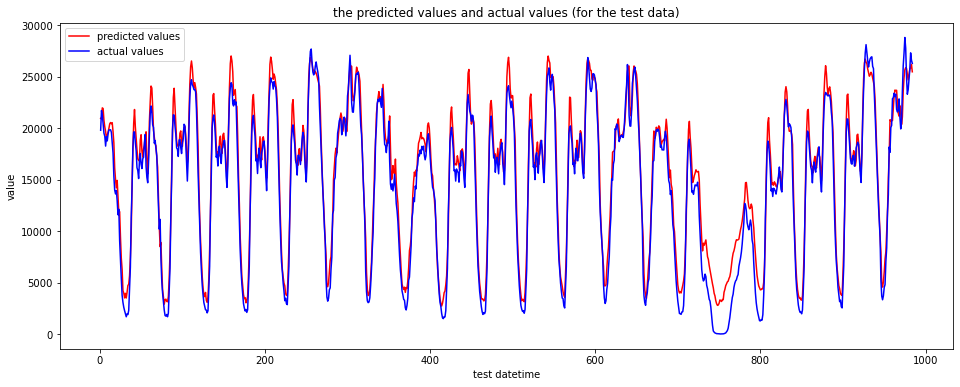

In [78]:
plot_predict_actual_values(range(1, y_pred_unscale.shape[0]+1), y_pred_unscale, y_true_unscale, "value")

It can be seen from above image that currently in most of the "peaks" of the curve, predicted value is higher than real value. After training with Linex loss, underestimated samples now only account for **16.5%** of all samples.

In [79]:
calculate_underestimation_portion(y_pred_unscale, y_true_unscale)

0.16463414634146342

If you set `a` to a bigger value, the proportion of underestimation will be lower, but the gap between predicted value and real value will be bigger and bigger. Actually, it's a trade-off between underestimation penality and accuracy.